**Import dei pacchetti necessari**

In [ ]:
! pip install sklearn --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import gzip
import json
import joblib
import os
import re
import unicodedata

from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from matplotlib import pyplot as plt

import warnings
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.io.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Embedding, LSTM, GRU, Conv1D, AveragePooling1D, Flatten, MaxPooling1D

import sklearn
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.cluster import KMeans,DBSCAN
from sklearn import metrics

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


import os, logging

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

import tensorflow as tf
import tensorflow_hub as hub



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:

from google.colab import drive
drive.mount('/content/drive')
     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import**

In [ ]:
df=pd.read_excel("/content/LDA_260123.xlsx")
df2=pd.read_excel("/content/BeyondBlue_220123.xlsx")
LIWC= pd.read_csv("/content/LIWC-22 Results - BeyondBlue_220123 - LIWC Analysis.csv")


In [ ]:
LIWC.rename(columns={'Unnamed: 0':'Index'}, inplace=True)

In [ ]:
print(len(df))
print(len(df2))
print(len(LIWC))

14739
14739
14735


Add columns from topic db

In [ ]:
df2['Topic']=df['Dominant_Topic'].astype(str)

In [ ]:
LIWC.rename(columns={"0":'Text'}, inplace=True)

Add columns from LIWC db

In [ ]:
LIWC=LIWC[["Index","Text","Tone","WPS","BigWords","Linguistic","function","pronoun","ppron","i","we","you","shehe","they","ipron",
"det","article","number","prep","auxverb","adverb","conj","negate","verb","adj","quantity","Drives","affiliation","achieve","power","Cognition","allnone",
"cogproc","insight","cause","discrep","tentat","certitude","differ","memory","Affect","tone_pos","tone_neg","emotion","emo_pos","emo_neg","emo_anx",
"emo_anger","emo_sad","swear","Social","socbehav","prosocial","polite","conflict","moral","comm","socrefs","family","friend","female","Physical",
"health","illness","wellness","mental","substances","sexual","food","death","need","want","acquire","lack","fulfill","fatigue","reward","risk",
"curiosity","allure","Perception","attention","motion","space","visual","auditory","feeling","time","focuspast","focuspresent","focusfuture"
]]
print(len(LIWC))

14735


In [ ]:
df2.rename(columns={'Unnamed: 0':'Index'}, inplace=True)
#df2['category']=df['Category']
if 'Category' in list(set(df2.columns)):
  df2.rename(columns={'Category':'category'},inplace=True)
if 'text' in list(set(df2.columns)):
  df2.rename(columns={'text':'Text'},inplace=True)  
df2=df2.rename(columns={0:'Text'})

In [ ]:
df2 = pd.merge(df2, LIWC, how="left", on='Text')


In [ ]:
df2.category=df2.category.str.replace("Suicide", "0")
df2.category=df2.category.str.replace("depression", "1")
df2.category=df2.category.str.replace("Anxiety", "2")
df2.category=df2.category.str.replace("PTSD and Trauma", "3")

In [ ]:
df2['Label']=0
df2.loc[df2.category=='0','Label']=1
#df2.rename(columns={0:'Text'}, inplace=True)

In [ ]:
df2['category'].value_counts()

2    6528
1    5590
3    1730
0     891
Name: category, dtype: int64

In [ ]:
# Drop rows where the "Text" column is empty
df2.dropna(subset=["Text"], inplace=True)


In [ ]:
# Define a function to calculate the first person rate for a given text sample
def calculate_first_person_rate(text):
    # Convert the text to lowercase
    text = text.lower()
    # Count the occurrences of the first person pronouns
    first_person_count = text.count("i") + text.count("am") + text.count("i'm") + text.count("me") + text.count("mine")
    # Count the total number of words in the text
    total_word_count = len(text.split())

    if total_word_count == 0:
      first_person_rate = 0
    else:


       # Calculate the first person rate
      first_person_rate = first_person_count / total_word_count
      return first_person_rate

# Apply the function to the "Text" column of the DataFrame
df2['First person rate'] = df2['Text'].apply(calculate_first_person_rate)

# Display the resulting DataFrame
print(df2)

       Index_x                                               Text category  \
0            1             Safety planning involves creating a...        0   
1            2             Life gets pretty hard sometimes and...        0   
2            3             I feel like I have heaps of people ...        0   
3            4             i'm having such a hard time lately....        0   
4            5             I just need to write down how I’m f...        0   
...        ...                                                ...      ...   
14734     1899             Hi Last year my husband was diagnos...        3   
14735     1900             I was recently involved in a trauma...        3   
14736     1901             On the outside everyone thinks we a...        3   
14737     1902             Hi, I am new to this and really don...        3   
14738     1903             just want to say hello. im struggin...        3   

      Topic  Index_y   Tone    WPS  BigWords  Linguistic  funct

In [ ]:
#df2.rename(columns={"Doc":"Text"}, inplace=True)
#df2.drop( axis=1, index=3, inplace=True)

**Pre-processing**



*   Tokenization
*   Normalization
*   Lemmatization
*   Stop-words removal
*   Addictional









In [ ]:
# replace delle abbreviazioni
def replace_words(data_text):
  data_text = data_text.str.lower()
  data_text = data_text.replace('\n','', regex=True).\
                                      replace('won\'t','will not', regex=True).\
                                      replace('n\'t',' not', regex=True).\
                                      replace('\'d',' would', regex=True).\
                                      replace('\'s',' is', regex=True).\
                                      replace('\'m',' am', regex=True).\
                                      replace('\'ll',' will', regex=True).\
                                      replace('\'ve',' have', regex=True).\
                                      replace('\'re',' are', regex=True).\
                                      replace('ying','y', regex=True)
  
  return data_text


# rimozione degli accenti (e.g. à -> a)
def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', str(input_str))
  return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


# rimozione duplicati e nulli
def drop_nan_dup(data):
  data.Text.replace('NaN', np.nan, regex=True).dropna(inplace=True)
  data.drop_duplicates(inplace=True)
  data.dropna(inplace=True)
  print(len(data))

# rimozione di caratteri numerici e punteggiatura
def remove_num_symb(data):
  data = data.replace('[^\w\s]','', regex=True).\
              replace('\.',' ', regex=True).\
              replace('\d+','', regex=True)
  return data

In [ ]:
# vengono estese le forme contratte
df2['Text'] = replace_words(df2['Text'])

print(df2.head(2))

# vengono rimpizzate le lettere con gli accenti, con quelle senza accenti
df2['Text'] = df2['Text'].apply(remove_accents)

print(df2.head(2))


# # vengono rimosse le istanze nulle e i duplicati
# drop_nan_dup(df2)
# df2.Text.isna().sum()

# print(df2.head(2))



# vengono rimossi i simboli, punteggiatura e numeri
df2.Text = remove_num_symb(df2.Text)

   Index_x                                               Text category Topic  \
0        1             safety planning involves creating a...        0     1   
1        2             life gets pretty hard sometimes and...        0     0   

   Index_y   Tone    WPS  BigWords  Linguistic  function  ...  space  visual  \
0      1.0  95.26  19.40     25.09       64.26     52.58  ...   3.78    0.34   
1      2.0  38.61  24.63     20.56       72.84     58.12  ...   7.61    0.25   

   auditory  feeling  time  focuspast  focuspresent  focusfuture  Label  \
0       0.0     0.69  1.72       2.41          6.19         3.78      1   
1       0.0     1.02  3.55       3.05          6.09         2.28      1   

   First person rate  
0           0.320946  
1           0.367089  

[2 rows x 96 columns]
   Index_x                                               Text category Topic  \
0        1             safety planning involves creating a...        0     1   
1        2             life gets pretty 

**Tokenization e Lemmatization**

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:

tok_ = nltk.tokenize.WhitespaceTokenizer()
lemm_ = nltk.stem.WordNetLemmatizer()

def lemmatize_text_verb(text):
    return [lemm_.lemmatize(w,'v') for w in tok_.tokenize(text)]
def lemmatize_text_adj(text):
    return [lemm_.lemmatize(w, 'a') for w in text]
def lemmatize_text(text):
    return [lemm_.lemmatize(w) for w in text]

df2.Text = df2.Text.apply(lemmatize_text_verb).apply(lemmatize_text_adj).apply(lemmatize_text)

In [ ]:
def tokeniz(text):
    return [w for w in tok_.tokenize(text)]

In [ ]:
# viene creato un nuovo dataframe per dedicato alla risoluzione del task di classificazione (suicidio o no)
df2_suicidio = df2.copy()


# viene unita la negazione alla parola successiva (e.g. not useful --> not_useful)
df2_suicidio['Text'] = df2_suicidio['Text'].replace('not\s','not_',regex=True).\
                                              replace('nor\s','nor_',regex=True).\
                                              replace('no\s','no_',regex=True).\
                                              replace('neither\s','neither_',regex=True)  
  
df2_suicidio['Text']= df2_suicidio['Text'].astype(str)                                                            
df2_suicidio.Text = df2_suicidio.Text.apply(tokeniz)
     

In [ ]:
# vengono rimosse le stop words 
stop = stopwords.words('english')

df2.Text = df2.Text.apply(lambda x: [item for item in x if item not in stop])
df2_suicidio.Text = df2_suicidio.Text.apply(lambda x: [item for item in x if item not in stop])

In [ ]:
def join_terms(sentence):
  sentence = ' '.join(sentence)
  return sentence
     

In [ ]:
# vengono ricreate le frasi e creati dei dump
df2.Text = df2.Text.apply(join_terms)
df2_suicidio.Text = df2_suicidio.Text.apply(join_terms)



**DA QUI**

In [ ]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

summary statistics

In [ ]:
df2.describe()

,Index_x,Index_y,Tone,WPS,BigWords,Linguistic,function,pronoun,ppron,i,...,space,visual,auditory,feeling,time,focuspast,focuspresent,focusfuture,Label,First person rate
count,14739.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,...,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14735.000000,14739.000000,14739.000000
mean,3258.360472,3258.439294,17.218333,22.302164,15.055346,77.707171,61.733945,18.898155,13.205459,10.898137,...,5.241503,0.613103,0.188380,1.486978,5.820466,4.770711,6.966360,1.226303,0.060452,0.386882
std,2301.967541,2302.074013,22.543123,23.181185,4.473936,5.560682,5.155029,4.057897,3.573349,3.506240,...,2.379182,0.860039,0.493956,1.391699,2.574234,2.874153,2.858532,1.289055,0.238330,0.060461
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1113.000000,1113.000000,1.340000,14.170000,12.275000,74.855000,59.090000,16.470000,11.070000,9.010000,...,3.740000,0.000000,0.000000,0.520000,4.170000,2.700000,5.090000,0.280000,0.000000,0.351562
50%,2964.000000,2964.000000,7.330000,18.000000,14.710000,78.130000,62.100000,18.880000,13.200000,11.110000,...,5.100000,0.420000,0.000000,1.210000,5.660000,4.510000,6.780000,0.990000,0.000000,0.385321
75%,5264.000000,5264.000000,20.230000,23.065000,17.350000,81.195000,64.950000,21.430000,15.380000,13.060000,...,6.560000,0.900000,0.220000,2.090000,7.250000,6.515000,8.590000,1.760000,0.000000,0.419847
max,7836.000000,7836.000000,99.000000,612.000000,100.000000,100.000000,100.000000,50.000000,50.000000,50.000000,...,28.570000,33.330000,12.500000,16.670000,25.000000,50.000000,50.000000,30.000000,1.000000,1.639640


In [ ]:
df2.groupby('Label').describe().T

Label                               0           1
Index_x           count  13848.000000  891.000000
                  mean    3433.594021  534.865320
                  std     2264.046077  308.876889
                  min        1.000000    1.000000
                  25%     1378.750000  268.500000
...                               ...         ...
First person rate min        0.000000    0.125000
                  25%        0.351989    0.345842
                  50%        0.385714    0.380000
                  75%        0.420101    0.413418
                  max        1.639640    0.666667

[736 rows x 2 columns]

** Visualize whole text using wordcloud**

In [ ]:
text1=str(df2.Text.astype(str))

In [ ]:
text1

'0        safety plan involve create structure plan idea...\n1        life get pretty hard sometimes many people onl...\n2        feel like heap people around support yet one t...\n3        hard time lately person uk think good close fr...\n4        need write im feel im exhaust pain overwhelm g...\n                               ...                        \n14734    hi last year husband diagnose ptsd begin treat...\n14735    recently involve traumatic situation one best ...\n14736    outside everyone think perfect couple young bl...\n14737    hi new really know however need something posi...\n14738    want say hello im strugging lifei cptsdand sex...\nName: Text, Length: 14739, dtype: object'

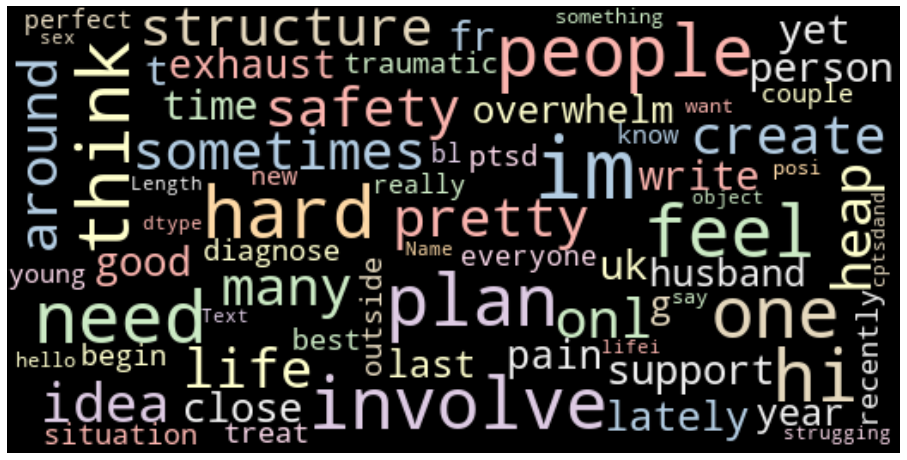

In [ ]:
sui_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(text1)
plt.figure(figsize=(16,10))
plt.imshow(sui_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

The WordCloud of the Suicide message:

In [ ]:
text2=str(df2.loc[df2.Label==1, 'Text'].astype(str))

In [ ]:
text2

'0      safety plan involve create structure plan idea...\n1      life get pretty hard sometimes many people onl...\n2      feel like heap people around support yet one t...\n3      hard time lately person uk think good close fr...\n4      need write im feel im exhaust pain overwhelm g...\n                             ...                        \n886    year ago find wife rap propose year ago keep s...\n887    awhile since last post long time try get good ...\n888    hi sure start goesi feel toxic place family af...\n889    hi sure find support group yo son attempt end ...\n890    decide become beyond blue volunteer speaker go...\nName: Text, Length: 891, dtype: object'

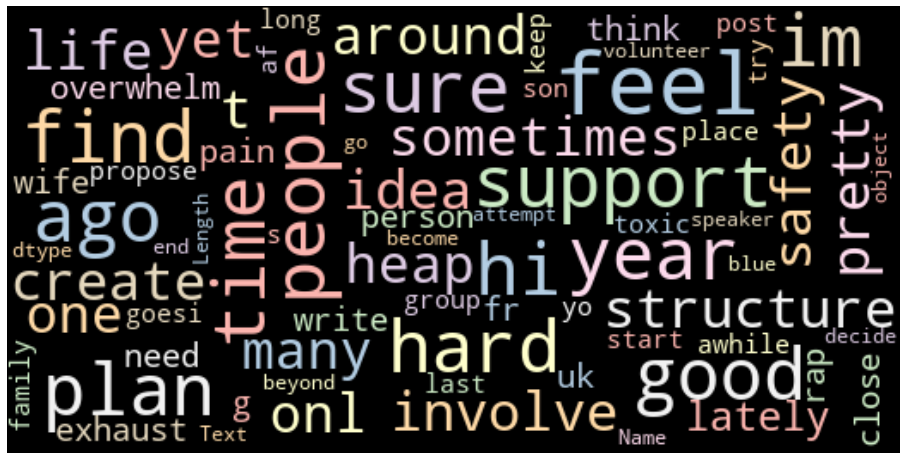

In [ ]:
sui_msg_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(text2)
plt.figure(figsize=(16,10))
plt.imshow(sui_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

 Handling imbalance data

Text(0.5, 1.0, 'Distribution')

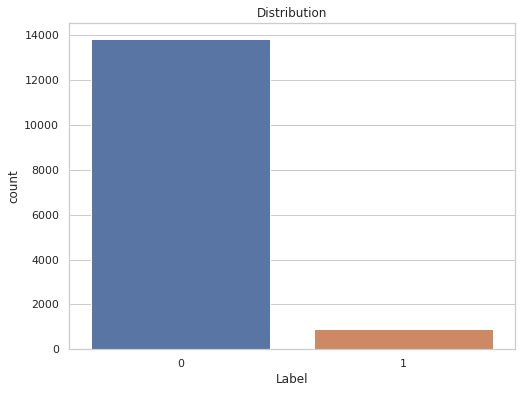

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df2.Label)
plt.title('Distribution')

In [ ]:
df2.loc[df2.Label==1, 'Text'].count()

891

In [ ]:
suicide=df2.loc[df2.Label==1]

In [ ]:
df2=df2.loc[df2.Label==0]

Text(0.5, 1.0, 'Distribution')

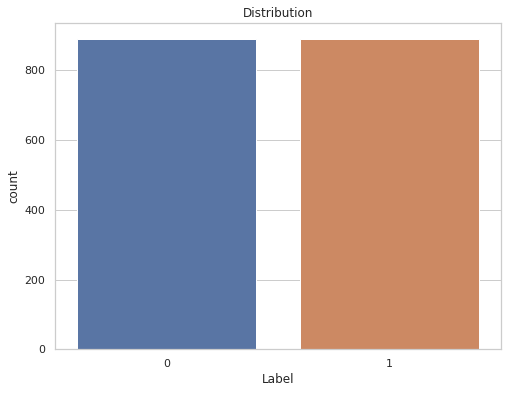

In [ ]:
# downsample the DF
df3 = df2.sample(n = 891, random_state = 0)
df3 = df3.append(suicide)


plt.figure(figsize=(8,6))
sns.countplot(df3.Label)
plt.title('Distribution')

**Text preprocessing**

**Train test split**

After that we do a train test split to divide the data into 80% train data and 30% test data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df3[[#'Text', 'Topic',  
                                                         'Tone', 'WPS',
       'BigWords', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'we',
       'you', 'shehe', 'they', 'ipron', 'det', 'article', 'number', 'prep',
       'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'quantity',
       'Drives', 'affiliation', 'achieve', 'power', 'Cognition', 'allnone',
       'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude',
       'differ', 'memory', 'Affect', 'tone_pos', 'tone_neg', 'emotion',
       'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'swear',
       'Social', 'socbehav', 'prosocial', 'polite', 'conflict', 'moral',
       'comm', 'socrefs', 'family', 'friend', 'female', 'Physical', 'health',
       'illness', 'wellness', 'mental', 'substances', 'sexual', 'food',
       'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue',
       'reward', 'risk', 'curiosity', 'allure', 'Perception', 'attention',
       'motion', 'space', 'visual', 'auditory', 'feeling', 'time', 'focuspast',
       'focuspresent', 'focusfuture',  'First person rate']], df3['Label'], test_size=0.3, random_state=0)

**Feature selection**

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2


# Select the top 20 features using chi2 test
selector = SelectKBest(score_func=chi2, k=20)
X_new = selector.fit_transform(x_train, y_train)

# Get the selected feature names
selected_feature_names = x_train.columns[selector.get_support()]
print(selected_feature_names)


Index(['Tone', 'BigWords', 'pronoun', 'ppron', 'i', 'negate', 'verb',
       'Cognition', 'allnone', 'discrep', 'emotion', 'emo_neg', 'emo_anx',
       'food', 'death', 'want', 'risk', 'curiosity', 'motion', 'focuspresent'],
      dtype='object')


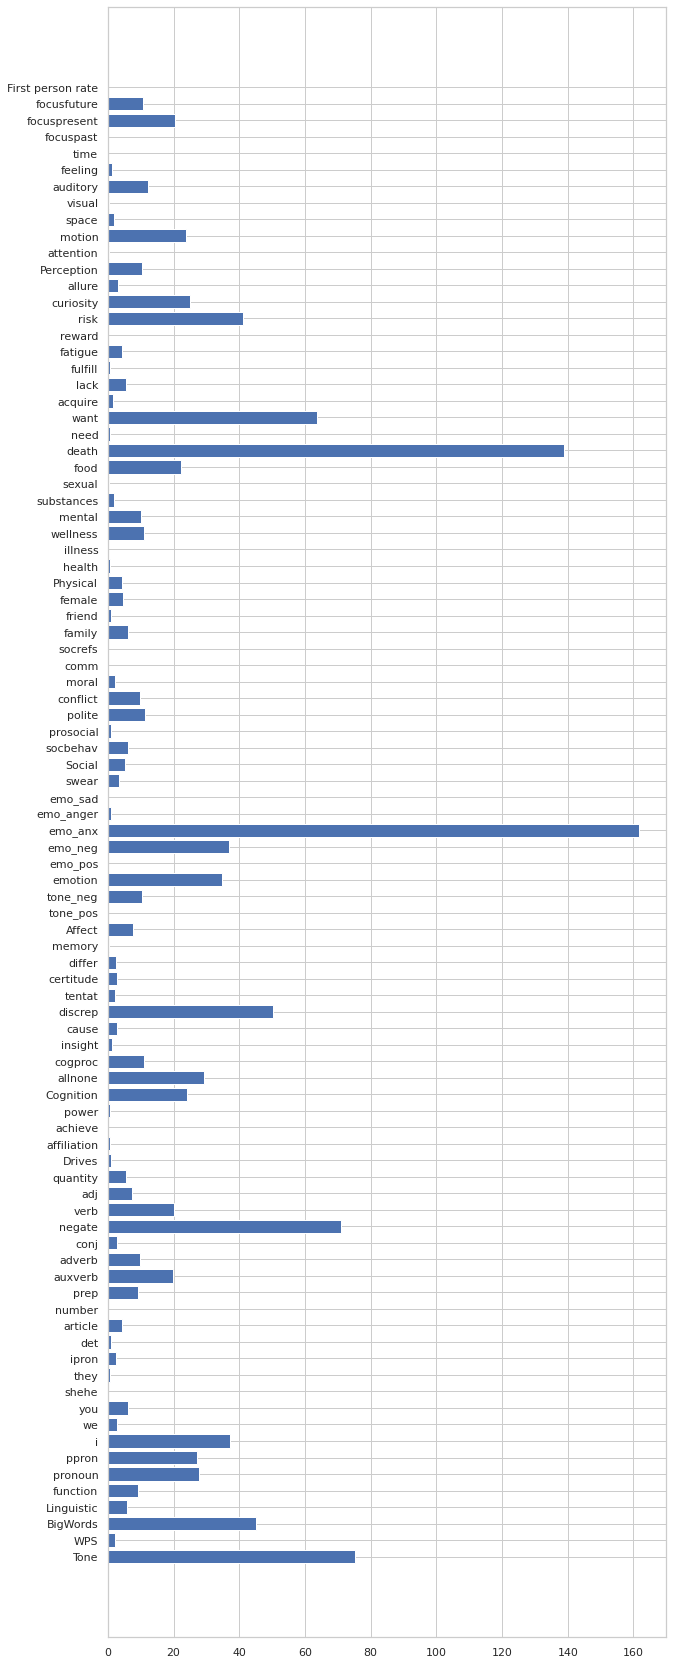

In [ ]:
import matplotlib.pyplot as plt

# Get the feature scores from the selector
scores = selector.scores_



# Create a bar plot of the scores
fig = plt.figure(figsize=(10,30)) # set the figure size

# Create a bar plot of the scores
plt.barh(range(len(scores)), scores)

# Add feature names as x-axis labels
plt.yticks(range(len(scores)), x_train.columns, rotation=0)

# Show the plot
plt.show()


In [ ]:
df3=df3[['Text','Topic','Tone', 'BigWords', 'pronoun', 'ppron', 'i', 'negate', 'verb',
       'Cognition', 'allnone', 'discrep', 'emotion', 'emo_neg', 'emo_anx',
       'food', 'death', 'want', 'risk', 'curiosity', 'motion', 'focuspresent', 'Label']]

**Tokenization**

In [ ]:
# Defining pre-processing parameters
max_len = 200 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 200

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

92

In [ ]:
df3.head(2)

,Text,Topic,Tone,BigWords,pronoun,ppron,i,negate,verb,Cognition,...,emo_neg,emo_anx,food,death,want,risk,curiosity,motion,focuspresent,Label
12370,lose good friend today say lose push away,3,1.00,15.38,15.38,15.38,7.69,7.69,38.46,7.69,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,7.69,0.00,0
4850,really need guidance accept new job start day ...,2,3.56,11.36,20.45,18.18,17.05,2.27,23.86,15.91,...,3.41,1.14,0.0,0.0,2.27,1.14,0.0,4.55,6.82,0


In [ ]:
df3.columns

Index(['Text', 'Topic', 'Tone', 'BigWords', 'pronoun', 'ppron', 'i', 'negate',
       'verb', 'Cognition', 'allnone', 'discrep', 'emotion', 'emo_neg',
       'emo_anx', 'food', 'death', 'want', 'risk', 'curiosity', 'motion',
       'focuspresent', 'Label'],
      dtype='object')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df3[[ 'Text', 'Topic', 'Tone', 'BigWords', 'pronoun', 'ppron', 'i', 'negate',
       'verb', 'Cognition', 'allnone', 'discrep', 'emotion', 'emo_neg', 'emo_anx', 'food', 'death', 'want', 'risk', 'curiosity', 'motion', 'focuspresent' ]],df3['Label'], test_size=0.3, random_state=0)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC



In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
                     

# # Categorical pipeline
categorical_preprocessing = Pipeline(
 [
     ('Imputation', SimpleImputer(strategy='constant')),
     ('One Hot Encoding', OneHotEncoder(handle_unknown='ignore')),
 ]
 )

# # Numeric pipeline
numeric_preprocessing = Pipeline(
 [
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # Numeric pipeline
numeric_preprocessing2 = Pipeline( 
    [
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # Numeric pipeline
numeric_preprocessing3 = Pipeline(
 [
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
 ]
 )

# # Numeric pipeline
numeric_preprocessing4 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )

# # Numeric pipeline
numeric_preprocessing5 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )

# # Numeric pipeline
numeric_preprocessing6 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )

# # Numeric pipeline
numeric_preprocessing7 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing8 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing9 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing10 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing11 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing12 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing13 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing14 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing15 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing16 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing17 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing18 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )


# # # Numeric pipeline
numeric_preprocessing19 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )



# # # Numeric pipeline
numeric_preprocessing20 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )



# # # Numeric pipeline
numeric_preprocessing21 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )



# # # Numeric pipeline
numeric_preprocessing22 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )



# # # Numeric pipeline
numeric_preprocessing23 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )



# # # Numeric pipeline
numeric_preprocessing24 = Pipeline(
[
      ('Imputation', SimpleImputer(strategy='mean', fill_value='?')),
      ('Scaling', StandardScaler())
 ]
 )

text_preprocessing = Pipeline(
[
      ('Text',TfidfVectorizer())       
 ] 
 )

# # Creating preprocessing pipeline
preprocessing = make_column_transformer(
      (numeric_preprocessing, [ 'Tone']),
      (numeric_preprocessing2, ['BigWords']),
      (numeric_preprocessing3, ['pronoun']),
      (numeric_preprocessing4, ['ppron']),
      (numeric_preprocessing5, ['i']),
      (numeric_preprocessing6, ['negate']),
      (numeric_preprocessing7, ['verb']),
      (numeric_preprocessing8, [ 'Cognition']), 
      (numeric_preprocessing9, [ 'allnone']),   
      (numeric_preprocessing10, [ 'Cognition']),                   
      (numeric_preprocessing11, [ 'discrep']),   
      (numeric_preprocessing12, ['emotion']),   
      (numeric_preprocessing13, ['emo_neg']),   
      (numeric_preprocessing14, [ 'emo_anx']),   
      (numeric_preprocessing15, [ 'food']),   
      (numeric_preprocessing16, ['death']),   
      (numeric_preprocessing17, [ 'want']),   
      (numeric_preprocessing18, [ 'risk']),                     
      (numeric_preprocessing19, [ 'curiosity']),   
      (numeric_preprocessing20, [ 'motion']),        
      (numeric_preprocessing21, [ 'focuspresent']),    
           		 

      (categorical_preprocessing, ['Topic']),
      (text_preprocessing, 'Text'),
 )

# # Final pipeline
pipeline = Pipeline(
 [('Preprocessing', preprocessing)])

x_train_ = pipeline.fit_transform(x_train)
x_test_ = preprocessing.transform(x_test)


In [ ]:
# SVC
clf_s= SVC().fit(x_train_, y_train)
clf_s.score(x_test_, y_test)

0.697196261682243

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0).fit(x_train_, y_train)
clf_lr.score(x_test_, y_test)

0.7588785046728972

Naive Bayes

In [ ]:
x_test_dense=x_test_.toarray()
x_train_dense=x_train_.toarray()

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train_dense, y_train).predict(x_test_dense)
print("Number of mislabeled points out of a total %d points : %d"     
      % (x_test_dense.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 535 points : 198


In [ ]:
from sklearn.naive_bayes import CategoricalNB

In [ ]:
clf = CategoricalNB()

In [ ]:
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
x_train_dense = scaler.fit_transform(x_train_dense)
x_test_dense = scaler.transform(x_test_dense)

In [ ]:
clf.fit(x_train_dense, y_train)
clf.score(x_train_dense, y_train)

0.9823576583801122

ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [ ]:
clf3 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf3.fit(x_train_dense, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [ ]:
clf3.score(x_train_dense, y_train)

0.9591018444266239

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}

base_estimator = RandomForestClassifier(random_state=0)

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=2, resource='n_estimators',
                          max_resources=30).fit(x_train_dense, y_train)
sh.best_estimator_


RandomForestClassifier(max_depth=10, n_estimators=24, random_state=0)

In [ ]:
RandomForestClassifier(max_depth=5, n_estimators=24, random_state=0)

RandomForestClassifier(max_depth=5, n_estimators=24, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rfc = RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=24, random_state=0)
rfc.fit(x_train_dense, y_train)
rfc.score(x_train_dense, y_train)

0.8652766639935846

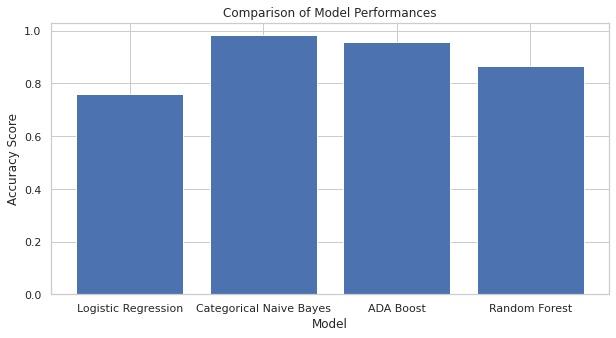

In [ ]:
import matplotlib.pyplot as plt

# Define the names of your models
models = ['Logistic Regression', 'Categorical Naive Bayes', 'ADA Boost', 'Random Forest']

# Define the performance of your models (for example, using accuracy scores)
scores = [clf_lr.score(x_test_, y_test), clf.score(x_train_dense, y_train), clf3.score(x_train_dense, y_train), rfc.score(x_train_dense, y_train)]

# creating the figure 
plt.figure(figsize=(10,5))  # width, height in inches

# Create the bar chart
plt.bar(models, scores)

# Add labels and a title
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Performances')

# Show the chart
plt.show()
